In [37]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

PREPROCESSED_ROOT = PROJECT_ROOT / "preprocessed_dataset"

print("PREPROCESSED_ROOT:", PREPROCESSED_ROOT)
print("PROJECT_ROOT:", PROJECT_ROOT)

PREPROCESSED_ROOT: E:\DL_audiotomidi\preprocessed_dataset
PROJECT_ROOT: E:\DL_audiotomidi


In [38]:
import math
import random
import numpy as np

import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

from models.rnn_amt import CompactBiGRU
from scripts.dataset_helpers import create_dataloaders
from scripts.evaluate import evaluate, frame_level_f1

import wandb

import time

In [39]:
# SPEC_TYPE="cqt" for CQT
SPEC_TYPE = "mel"
# N_FREQ_BINS=252 for CQT
N_FREQ_BINS = 229
N_PITCHES = 88

BATCH_SIZE = 16
CHUNK_LEN = 512
NUM_WORKERS = 4

NUM_EPOCHS = 100

BASE_LR = 3e-4
WEIGHT_DECAY = 5e-5
# WARMUP for Learning Rate
WARMUP_RATIO = 0.1

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HOP_LENGTH = 512
SR = 22050
# Binarization threshold
THRESHOLD = 0.5

In [40]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

In [41]:
train_loader, val_loader = create_dataloaders(
    root_dir=str(PREPROCESSED_ROOT),
    spec_type=SPEC_TYPE,
    batch_size=BATCH_SIZE,
    chunk_len=CHUNK_LEN,
    num_workers=NUM_WORKERS,
)

print("train batches:", len(train_loader))
print("val batches:", len(val_loader))

Train batches: 61
Val batches: 9


In [42]:
num_training_steps = NUM_EPOCHS * len(train_loader)
print("training steps:", num_training_steps)
num_warmup_steps = int(WARMUP_RATIO * num_training_steps)
print("warmup steps:",num_warmup_steps)

6100
610


In [43]:
def lr_lambda(current_step: int):
    # warmup
    if current_step < num_warmup_steps:
        return float(current_step) / max(1, num_warmup_steps)

    # cosine decay
    progress = float(current_step - num_warmup_steps) / max(
        1, num_training_steps - num_warmup_steps
    )
    return 0.5 * (1.0 + math.cos(math.pi * progress))

In [44]:
model = CompactBiGRU(
    input_dim=N_FREQ_BINS,
    n_pitches=N_PITCHES,
    proj_dim=96,
    hidden_dim=160,
    num_blocks=2,
    dropout=0.2,
).to(DEVICE)

optimizer = AdamW(
    model.parameters(),
    lr=BASE_LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

model

CompactBiGRU(
  (input_proj): Linear(in_features=229, out_features=128, bias=True)
  (blocks): Sequential(
    (0): ResidualBiGRUBlock(
      (gru): GRU(128, 176, batch_first=True, bidirectional=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (proj): Linear(in_features=128, out_features=352, bias=True)
      (norm): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
    )
    (1): ResidualBiGRUBlock(
      (gru): GRU(352, 176, batch_first=True, bidirectional=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (norm): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
    )
  )
  (head): Linear(in_features=352, out_features=88, bias=True)
)

In [45]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable:,}")

Trainable parameters: 990,136


In [11]:
#loss function weighted with a positive weight value
pos_weight_value = 5.0

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.full((N_PITCHES,), pos_weight_value, device=DEVICE)
)

In [12]:
def train_one_epoch(
    model: nn.Module,
    dataloader,
    criterion,
    optimizer,
    scheduler,
    device: torch.device,
    epoch: int,
    log_interval: int = 50
):
    model.train()
    running_loss = 0.0
    running_f1 = 0.0
    num_batches = 0

    for batch_idx, (spec, target) in enumerate(dataloader):

        spec = spec.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        logits = model(spec)

        # BCEWithLogitsLoss by all (frame, pitch)
        loss = criterion(
            logits.reshape(-1, logits.shape[-1]),
            target.reshape(-1, target.shape[-1])
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        batch_f1 = frame_level_f1(logits.detach(), target.detach(), threshold=THRESHOLD)

        running_loss += loss.item()
        running_f1 += batch_f1
        num_batches += 1

    epoch_loss = running_loss / max(1, num_batches)
    epoch_f1 = running_f1 / max(1, num_batches)

    return epoch_loss, epoch_f1

In [13]:
def train(model,
          train_dataloader,
          val_dataloader,
          criterion,
          optimizer,
          scheduler,
          device,
          n_epochs,
          run=None,
          checkpoint_path=None,
          threshold=0.5,
          hop_length=512,
          sr=22050,
          log_interval=50,
):
    
    global_step = 0
    best_val_frame_f1 = 0.0

    total_start = time.time()
    
    for epoch in range(1, n_epochs + 1):

        epoch_start = time.time()

        # training phase
        train_loss, train_frame_f1 = train_one_epoch(
            model=model,
            dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            epoch=epoch,
            log_interval=log_interval
        )
        
        train_time_sec = time.time() - epoch_start

        global_step = epoch * len(train_dataloader)

        # validation phase
        val_start = time.time()
        val_loss, val_frame_f1, _ = evaluate(
            model=model,
            dataloader=val_dataloader,
            criterion=criterion,
            device=device,
            threshold=threshold,
            hop_length=hop_length,
            sr=sr,
            onset_tolerance=0.05,
            compute_note_f1=False
        )

        val_time = time.time() - val_start
        epoch_time = time.time() - epoch_start

        print(
            f"[Epoch {epoch}/{n_epochs}] "
            f"train_loss={train_loss:.4f}, train_F1={train_frame_f1:.4f} | "
            f"val_loss={val_loss:.4f}, val_F1={val_frame_f1:.4f} | "
            f"train_time={train_time_sec:.1f}s"
        )

        current_lr = optimizer.param_groups[0]["lr"]

        #wandb logging
        if run is not None:
            run.log(
                {
                    "epoch": epoch,
                    "train/loss": train_loss,
                    "train/frame_F1": train_frame_f1,
                    "val/loss": val_loss,
                    "val/frame_F1": val_frame_f1,
                    "lr": current_lr,
                    "time/train_epoch_sec": epoch_time,
                },
                step=global_step
            )

        #saving the best checkpoint by val_frame metric
        if checkpoint_path is not None and val_frame_f1 > best_val_frame_f1:
            best_val_frame_f1 = val_frame_f1
            torch.save(
                {
                    "model_state_dict": model.state_dict()
                },
                checkpoint_path
            )
            print(f"*** New best frame-F1={best_val_frame_f1:.4f}, saved to {checkpoint_path} ***")

    total_time = time.time() - total_start
    print(f"\n=== TOTAL TRAINING TIME: {total_time/3600:.2f} hours ===")

    if run is not None:
        run.log({"time/total_hours": total_time / 3600.0}, step=global_step)

    return best_val_frame_f1

In [27]:
CHECKPOINT_DIR = PROJECT_ROOT / "checkpoints"
print(CHECKPOINT_DIR)

best_ckpt_path = CHECKPOINT_DIR / f"compactgru_bigger_{SPEC_TYPE}_best.pt"

E:\DL_audiotomidi\checkpoints


In [28]:
wandb_config = {
    "model": "BiGRU",
    "spec_type": SPEC_TYPE,
    "n_freq_bins": N_FREQ_BINS,
    "n_pitches": N_PITCHES,
    "batch_size": BATCH_SIZE,
    "chunk_len": CHUNK_LEN,
    "num_workers": NUM_WORKERS,
    "num_epochs": NUM_EPOCHS,
    "base_lr": BASE_LR,
    "weight_decay": WEIGHT_DECAY,
    "warmup_ratio": WARMUP_RATIO,
    "seed": SEED,
    "hop_length": HOP_LENGTH,
    "sr": SR,
    "threshold": THRESHOLD,
}

In [29]:
with wandb.init(
    project="DL_audiotomidi",
    name="CompactBiGRU_mel_bigger",
    config=wandb_config
) as run:

    best_val_frame_f1 = train(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=DEVICE,
        n_epochs=NUM_EPOCHS,
        run=run,
        checkpoint_path=best_ckpt_path,
        threshold=THRESHOLD,
        hop_length=HOP_LENGTH,
        sr=SR,
        log_interval=50
    )

print("Best validation frame-F1:", best_val_frame_f1)


=== Epoch 1/100 ===
[Epoch 1/100] train_loss=0.7861, train_F1=0.1249 | val_loss=0.6078, val_F1=0.1048 | train_time=50.5s
*** New best frame-F1=0.1048, saved to E:\DL_audiotomidi\checkpoints\compactgru_bigger_mel_best.pt ***

=== Epoch 2/100 ===
[Epoch 2/100] train_loss=0.6078, train_F1=0.0566 | val_loss=0.4747, val_F1=0.0022 | train_time=45.5s

=== Epoch 3/100 ===
[Epoch 3/100] train_loss=0.5710, train_F1=0.0194 | val_loss=0.4542, val_F1=0.0250 | train_time=44.8s

=== Epoch 4/100 ===
[Epoch 4/100] train_loss=0.5470, train_F1=0.0826 | val_loss=0.4307, val_F1=0.0947 | train_time=45.9s

=== Epoch 5/100 ===
[Epoch 5/100] train_loss=0.5076, train_F1=0.2834 | val_loss=0.3857, val_F1=0.3673 | train_time=43.3s
*** New best frame-F1=0.3673, saved to E:\DL_audiotomidi\checkpoints\compactgru_bigger_mel_best.pt ***

=== Epoch 6/100 ===
[Epoch 6/100] train_loss=0.4629, train_F1=0.4028 | val_loss=0.3401, val_F1=0.4293 | train_time=43.2s
*** New best frame-F1=0.4293, saved to E:\DL_audiotomidi\check

epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
lr,▂▅▇██████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
time/total_hours,▁
time/train_epoch_sec,▆▄▄▂▄▄▅▆▆▃▄▂█▃▁▄▅▁▄▁▃▄▃▅▁▃█▁▅▄▅▅▅▃▄▃▁▁▅▃
train/frame_F1,▂▁▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train/loss,█▆▅▅▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/frame_F1,▁▄▅▆▆▅▆▇▇▇▆▇█▇▇▇█▇█▇█▇██▇███████████████
val/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
lr,0
time/total_hours,1.51382


Best validation frame-F1: 0.673434626724809


In [47]:
ckpt = torch.load(best_ckpt_path, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
model.to(DEVICE)
model.eval()

CompactBiGRU(
  (input_proj): Linear(in_features=229, out_features=128, bias=True)
  (blocks): Sequential(
    (0): ResidualBiGRUBlock(
      (gru): GRU(128, 176, batch_first=True, bidirectional=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (proj): Linear(in_features=128, out_features=352, bias=True)
      (norm): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
    )
    (1): ResidualBiGRUBlock(
      (gru): GRU(352, 176, batch_first=True, bidirectional=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (norm): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
    )
  )
  (head): Linear(in_features=352, out_features=88, bias=True)
)

In [48]:
from scripts.dataset_helpers import PianoRollDataset
from torch.utils.data import DataLoader

TEST_CHUNK_LEN = 512  # for CNN we don't need to chop the spectrogram into chunks, 
                      # but for RNN and CRNN we have to
TEST_BATCH_SIZE = 8

test_ds = PianoRollDataset(
    root_dir=str(PREPROCESSED_ROOT),
    split="test",
    spec_type=SPEC_TYPE,
    chunk_len=TEST_CHUNK_LEN,
    random_crop=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [17]:
from scripts.evaluate import compute_frame_micro_metrics

frame_metrics = compute_frame_micro_metrics(
    model,
    test_loader,
    DEVICE,
    threshold=0.6
)

print("=== Test frame-level metrics ===")
for k, v in frame_metrics.items():
    if k in ("tp", "fp", "fn"):
        continue
    print(f"{k}: {v * 100:.2f}%")

=== Test frame-level metrics ===
accuracy: 97.55%
precision: 65.90%
recall: 75.87%
frame_f1: 70.53%


In [45]:
from scripts.evaluate import compute_note_micro_metrics

note_metrics = compute_note_micro_metrics(
    model,
    test_loader,
    DEVICE,
    threshold=0.8,
    hop_length=HOP_LENGTH,
    sr=SR,
    onset_tolerance=0.05
)

print("=== Test note-level metrics ===")
for k, v in note_metrics.items():
    if k in ("tp", "fp", "fn"):
        continue
    print(f"{k}: {v * 100:.2f}%")

=== Test note-level metrics ===
accuracy: 35.10%
precision: 46.27%
recall: 59.25%
note_f1: 51.97%


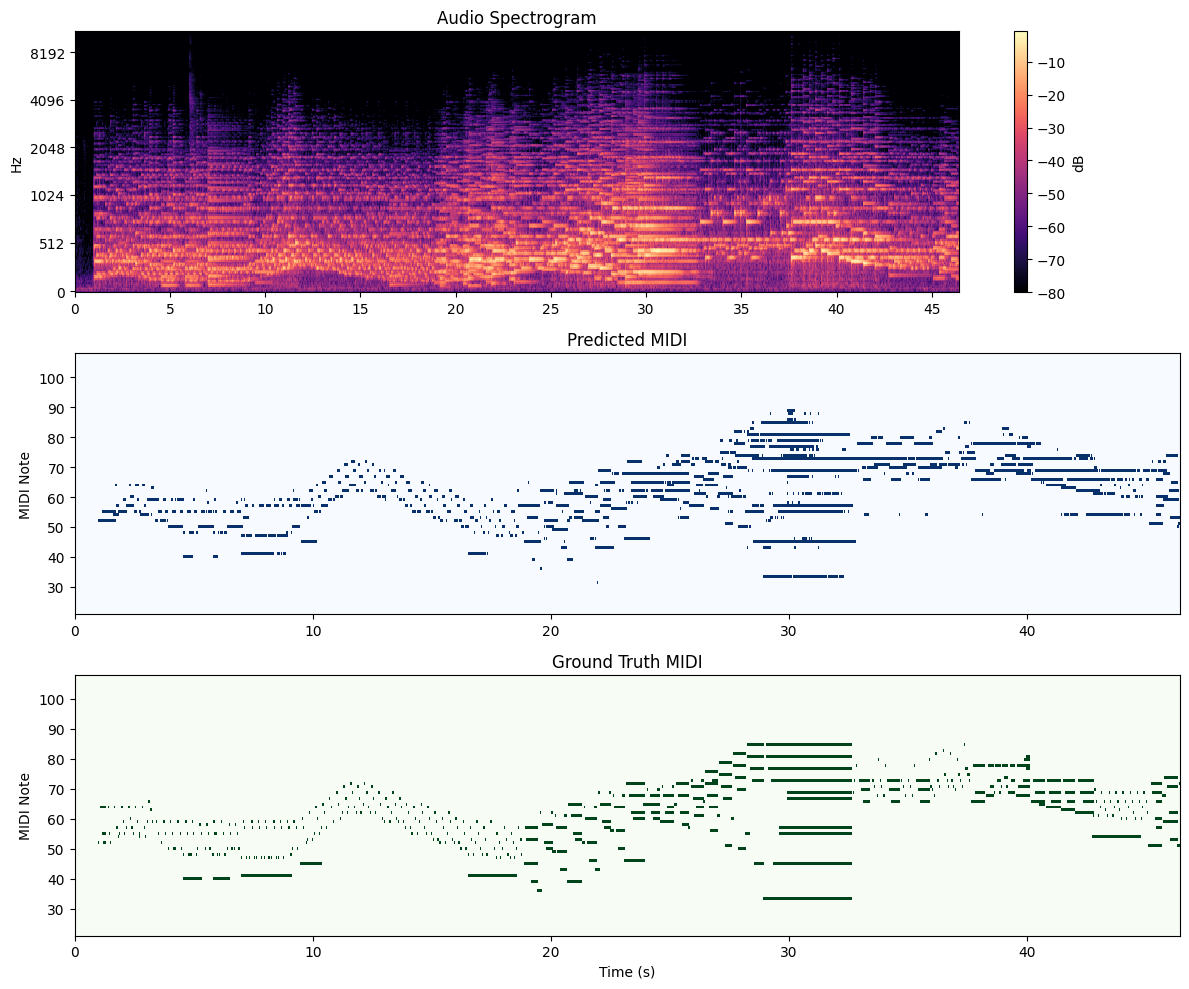

In [49]:
from scripts.inference.py import get_piano_roll, predict, plot_comparison, measure_efficiency

# Test track with corresponding MIDI
AUDIO_PATH = "test_long.wav"
MIDI_PATH = "test_long.midi"




audio, _ = librosa.load(AUDIO_PATH, sr=SR, mono=True)

pred_probs, spec = predict(model, audio, DEVICE)

gt_roll = get_piano_roll(MIDI_PATH, SR, HOP_LENGTH)

plot_comparison(spec, pred_probs, gt_roll, SR, HOP_LENGTH)

In [ ]:
stats = measure_efficiency(model, device='cpu', duration_sec=60)

In [35]:
import time
import torch
from thop import profile
from thop import clever_format

def measure_efficiency(model, device='cpu', duration_sec=60):
    """
    Измеряет параметры модели, FLOPS и время инференса на 1 минуту аудио.
    """
    model.to(device)
    model.eval()
    
    # Создаем фейковый инпут: 1 минута аудио
    # T = duration * SR / HOP_LENGTH
    # Пример: 60 * 22050 / 512 ≈ 2584 фрейма
    # Shape: (1, 1, F, T) для CNN/CRNN или (1, 1, F, T) -> squeeze внутри RNN
    
    frames_count = int(duration_sec * 22050 / 512)
    dummy_input = torch.randn(1, 1, 229, frames_count).to(device) # 229 mel bins
    
    # 1. Измерение параметров
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # 2. Измерение FLOPS (Macs)
    # thop может ругаться на RNN, но для CNN/CRNN работает хорошо
    try:
        macs, params = profile(model, inputs=(dummy_input, ), verbose=False)
        macs_str, params_str = clever_format([macs, params], "%.3f")
    except Exception as e:
        print(f"FLOPS calculation failed: {e}")
        macs, macs_str = 0, "N/A"

    # 3. Измерение времени инференса (Latency)
    # Делаем прогрев
    with torch.no_grad():
        for _ in range(5):
            _ = model(dummy_input)
            
    # Замер
    start_time = time.time()
    n_runs = 10
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(dummy_input)
            
    avg_time = (time.time() - start_time) / n_runs
    rtf = avg_time / duration_sec # Real-Time Factor
    
    print(f"--- Efficiency Report ({device.upper()}) ---")
    print(f"Model: {type(model).__name__}")
    print(f"Input duration: {duration_sec} sec")
    print(f"Total Params: {total_params:,}")
    print(f"Trainable Params: {trainable_params:,}")
    print(f"MACs (FLOPs/2): {macs_str}")
    print(f"Avg Inference Time: {avg_time:.4f} sec")
    print(f"Real-Time Factor (RTF): {rtf:.4f} (Lower is better)")
    print(f"Speedup vs Real-time: {1/rtf:.1f}x")
    
    return {
        "params": total_params,
        "macs": macs,
        "inference_time": avg_time,
        "rtf": rtf
    }

# --- ПРИМЕР ЗАПУСКА ---
# Загрузи модель (как в прошлом скрипте)
# model = ... (load_model)

# Важно: меряем на CPU, так как это "on-device" сценарий
stats = measure_efficiency(model, device='cpu', duration_sec=60)

--- Efficiency Report (CPU) ---
Model: CompactBiGRU
Input duration: 60 sec
Total Params: 990,136
Trainable Params: 990,136
MACs (FLOPs/2): 2.572G
Avg Inference Time: 0.3432 sec
Real-Time Factor (RTF): 0.0057 (Lower is better)
Speedup vs Real-time: 174.8x
